In [ ]:
import os
import numpy as np
import pandas as pd
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
rng = np.random.default_rng(0)
az.style.use("arviz-darkgrid")
%matplotlib inline

### 1. Get SP500 data

In [ ]:
# !pip install yfinance

In [ ]:
import yfinance as yf

In [ ]:
# !pip install pandas_datareader

In [ ]:
import pandas_datareader.data as web
import datetime

In [ ]:
start = datetime.datetime(2000, 1, 1)
end = datetime.date.today()

sp500 = web.DataReader(['sp500'], 'fred', start, end)

In [ ]:
sp500.shape

(2609, 1)

In [ ]:
sp500.tail()

,sp500
DATE,
2022-02-02,4589.38
2022-02-03,4477.44
2022-02-04,4500.53
2022-02-07,4483.87
2022-02-08,4521.54


In [ ]:
df = yf.download(["spy"], start, end)
df.shape

[*********************100%***********************]  1 of 1 completed


(5562, 6)

In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-02,455.500000,458.119995,453.049988,457.350006,457.350006,117361000
2022-02-03,450.950012,452.970001,445.709991,446.600006,446.600006,118024400
2022-02-04,446.350006,452.779999,443.829987,448.700012,448.700012,118335600
2022-02-07,449.510010,450.989990,445.850006,447.260010,447.260010,84472900
2022-02-08,446.730011,451.920013,445.220001,450.940002,450.940002,80920800


In [ ]:
sp500["change"] = np.log(sp500["sp500"]).diff()

In [ ]:
sp500.isna().sum()

sp500     0
change    1
dtype: int64

In [ ]:
sp500 = sp500.dropna()

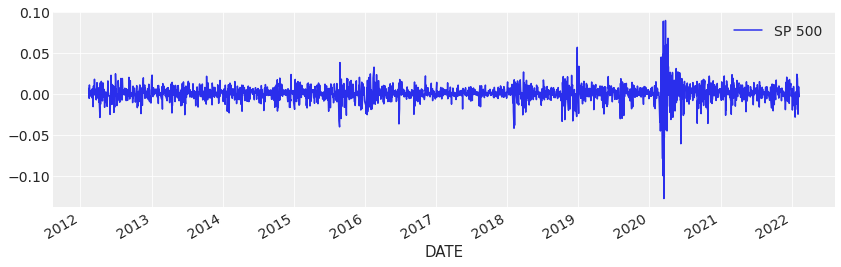

In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(14,4))
sp500.plot(y="change", label="SP 500", ax=ax);

### Model

In [ ]:
def make_sv_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, dims="time")
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-2*volatility), observed=data["change"])
    return model

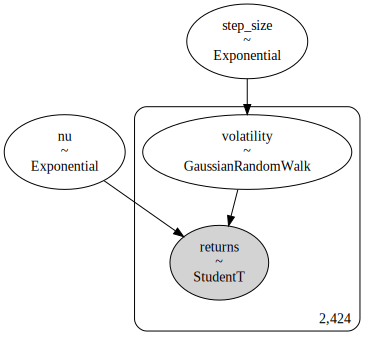

In [ ]:
model = make_sv_model(sp500)
pm.model_to_graphviz(model)

In [ ]:
with model:
    trace = az.from_pymc3(prior=pm.sample_prior_predictive(1000))

In [ ]:
prior_predictive = trace.prior_predictive.stack(pooled_chain=("chain", "draw"))

In [ ]:
prior_predictive

<xarray.Dataset>
Dimensions:        (pooled_chain: 1000, returns_dim_0: 2424)
Coordinates:
  * returns_dim_0  (returns_dim_0) int64 0 1 2 3 4 ... 2419 2420 2421 2422 2423
  * pooled_chain   (pooled_chain) MultiIndex
  - chain          (pooled_chain) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  - draw           (pooled_chain) int64 0 1 2 3 4 5 ... 994 995 996 997 998 999
Data variables:
    returns        (returns_dim_0, pooled_chain) float64 0.978 -5.39 ... -0.9386
Attributes:
    created_at:                 2022-02-09T10:47:05.609321
    arviz_version:              0.8.3
    inference_library:          pymc3
    inference_library_version:  3.9.0

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
sp500["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"].isel(pooled_chain=slice(4, 6, None)),
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

NameError: name 'returns' is not defined

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f58f561fc20> (for post_execute):


ValueError: view limit minimum -36909.700000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36909.700000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

### Fit Model

In [ ]:
with model:
    trace = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, volatility, step_size]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 162 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
ppc = trace.posterior.stack(pooled_chain=("chain", "draw"))
ppc["exp_volatility"] = np.exp(ppc["volatility"])

In [ ]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

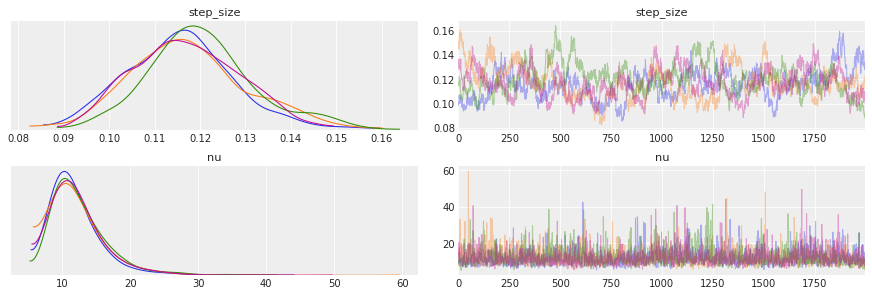

In [ ]:
az.plot_trace(trace, var_names=["step_size", "nu"]);

In [ ]:
y_vals

<xarray.DataArray 'exp_volatility' (volatility_dim_0: 2424, pooled_chain: 1600)>
array([[0.00646131, 0.00516091, 0.00538656, ..., 0.00990629, 0.00866851,
        0.00498061],
       [0.00664503, 0.00408705, 0.00537548, ..., 0.00996774, 0.00863175,
        0.00530116],
       [0.00614991, 0.00424955, 0.00518751, ..., 0.01118421, 0.00811963,
        0.00494406],
       ...,
       [0.01338241, 0.01378742, 0.02372446, ..., 0.0089899 , 0.00825121,
        0.01239012],
       [0.01283966, 0.01292127, 0.0186214 , ..., 0.01107762, 0.00747084,
        0.01224197],
       [0.01251316, 0.01514997, 0.01863008, ..., 0.01123598, 0.00713562,
        0.01258224]])
Coordinates:
  * volatility_dim_0  (volatility_dim_0) int64 0 1 2 3 4 ... 2420 2421 2422 2423
  * pooled_chain      (pooled_chain) MultiIndex
  - chain             (pooled_chain) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw              (pooled_chain) int64 0 5 10 15 20 ... 1980 1985 1990 1995

In [ ]:
y_vals


<xarray.DataArray 'exp_volatility' (volatility_dim_0: 2424, pooled_chain: 1600)>
array([[0.00646131, 0.00516091, 0.00538656, ..., 0.00990629, 0.00866851,
        0.00498061],
       [0.00664503, 0.00408705, 0.00537548, ..., 0.00996774, 0.00863175,
        0.00530116],
       [0.00614991, 0.00424955, 0.00518751, ..., 0.01118421, 0.00811963,
        0.00494406],
       ...,
       [0.01338241, 0.01378742, 0.02372446, ..., 0.0089899 , 0.00825121,
        0.01239012],
       [0.01283966, 0.01292127, 0.0186214 , ..., 0.01107762, 0.00747084,
        0.01224197],
       [0.01251316, 0.01514997, 0.01863008, ..., 0.01123598, 0.00713562,
        0.01258224]])
Coordinates:
  * volatility_dim_0  (volatility_dim_0) int64 0 1 2 3 4 ... 2420 2421 2422 2423
  * pooled_chain      (pooled_chain) MultiIndex
  - chain             (pooled_chain) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw              (pooled_chain) int64 0 5 10 15 20 ... 1980 1985 1990 1995

### Posterior predictive check

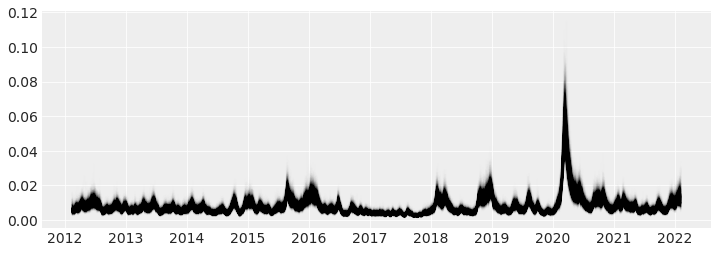

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
y_vals = ppc["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = pd.to_datetime(sp500.index)

plt.plot(x_vals, y_vals, "k", alpha=0.002);

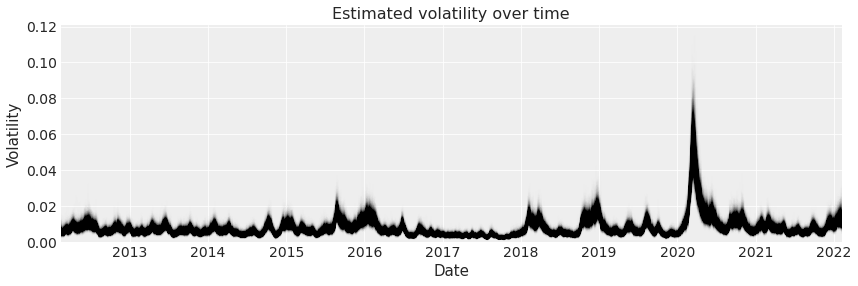

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = ppc["exp_volatility"].isel(pooled_chain=slice(None, None, 5))
x_vals = pd.to_datetime(sp500.index)#y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

In [ ]:
ppc

<xarray.Dataset>
Dimensions:           (pooled_chain: 8000, volatility_dim_0: 2424)
Coordinates:
  * volatility_dim_0  (volatility_dim_0) int64 0 1 2 3 4 ... 2420 2421 2422 2423
  * pooled_chain      (pooled_chain) MultiIndex
  - chain             (pooled_chain) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw              (pooled_chain) int64 0 1 2 3 4 ... 1996 1997 1998 1999
Data variables:
    volatility        (volatility_dim_0, pooled_chain) float64 -5.042 ... -4.237
    step_size         (pooled_chain) float64 0.09873 0.1006 ... 0.1053 0.1073
    nu                (pooled_chain) float64 14.42 11.11 8.847 ... 9.395 7.351
    exp_volatility    (volatility_dim_0, pooled_chain) float64 0.006461 ... 0.01445
Attributes:
    created_at:                 2022-02-09T10:52:17.790524
    arviz_version:              0.8.3
    inference_library:          pymc3
    inference_library_version:  3.9.0
    sampling_time:              161.50496339797974
    tuning_steps:               2000

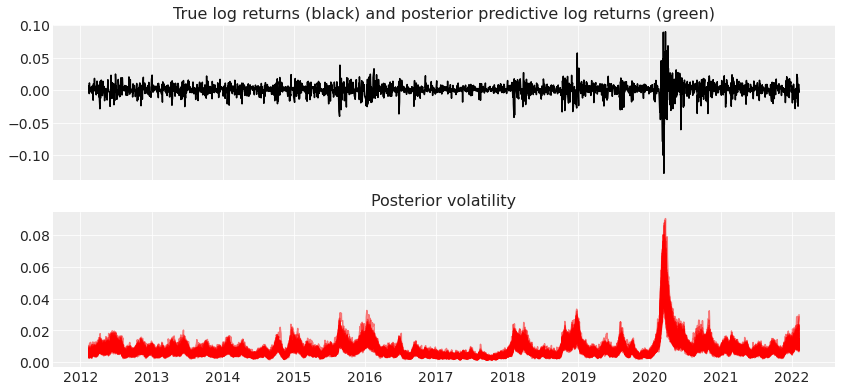

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
sp500["change"].plot(ax=axes[0], color="black")

axes[1].plot(x_vals, ppc["exp_volatility"].isel(pooled_chain=slice(None, None, 100)), "r", alpha=0.5)
# axes[0].plot(
#     x_vals,
#     ppc["returns"].isel(pooled_chain=slice(None, None, 100)),
#     "g",
#     alpha=0.5,
#     zorder=-10,
# )
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");